In [167]:
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import numpy as np
import datetime
import pandas as pd
from fitter import Fitter, get_common_distributions
import scipy

# Read in the CSV for charge information

In [168]:
df = pd.read_csv("charge_information.csv", usecols=(1, 2))

# Grab percent_full column
percentage_charged = df.iloc[:, 1].to_numpy()
df.head()

,percentage_needing_charged,percent_full
0,0.317632,0.682368
1,0.062474,0.937526
2,0.199968,0.800032
3,0.408232,0.591768
4,0.487821,0.512179


Text(0.5, 1.0, 'True Distribution from Data')

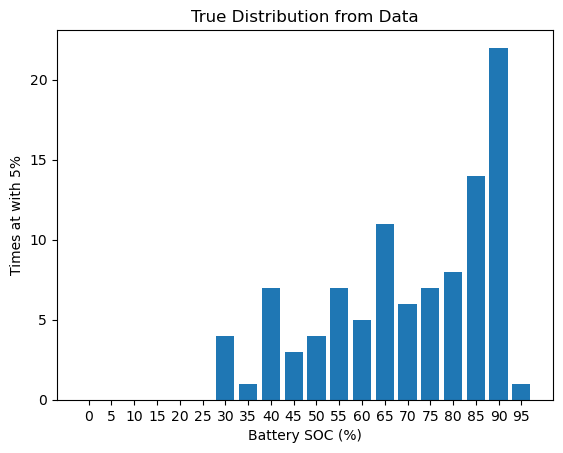

In [193]:
values = np.zeros(20)
labels = [5 * i for i in range(20)]

for charge in percentage_charged:
    if charge < 0.95:
        charge = int(round(charge, 2) * 100)
        index = charge // 5
        values[index] += 1
plt.bar(np.arange(values.size), values)
plt.xticks(ticks=np.arange(len(values)), labels=labels)
plt.xlabel("Battery SOC (%)")
plt.ylabel("Times at with 5%")
plt.title("True Distribution from Data")

## Bin into the 3 bins. Mostly Charged, Partially Charged and Barely Charged

In [169]:
times_mostly_charged = 0
times_partially_charged = 0
times_barely_charged = 0
mostly_charged = []
partially_charged = []
barely_charged = []

total_count = len(percentage_charged)

for charge in percentage_charged:
    # These don't make sense, other than they were caused during testing and starting and stopping the charge manually. This isn't an accurate amount of charge
    if charge > 0.95: 
        continue 
    
    if charge < 0.5:
        times_barely_charged += 1
        barely_charged.append(charge)
    elif charge < 0.75:
        times_partially_charged += 1
        partially_charged.append(charge)
    else:
        times_mostly_charged += 1
        mostly_charged.append(charge)

print(f"Times mostly charge: {times_mostly_charged}/{total_count}")
print(f"Times partially charge: {times_partially_charged}/{total_count}")
print(f"Times barely charge: {times_barely_charged}/{total_count}")


Times mostly charge: 51/151
Times partially charge: 34/151
Times barely charge: 15/151


## Compute the Likelihoods

In [170]:
likelihood_mostly_charged = times_mostly_charged / total_count
likelihood_partially_charged = times_partially_charged / total_count
likelihood_barely_charged = times_barely_charged / total_count

# likelihood_mostly_charged = likelihood(pi, times_mostly_charged, total_count)
# likelihood_partially_charged = likelihood(pi, times_partially_charged, total_count)
# likelihood_barely_charged = likelihood(pi, times_barely_charged, total_count)

print(f"Mostly Charged: {round((times_mostly_charged / total_count) * 100, 2)}%")
print(f"Partially Charged: {round((likelihood_partially_charged) * 100, 2)}%")
print(f"Barely Charged: {round((likelihood_barely_charged) * 100, 2)}%")

Mostly Charged: 33.77%
Partially Charged: 22.52%
Barely Charged: 9.93%


These probabilities will be the likelihood that we sample from that given distribution. Next, we will fit distributions to each of the bins we collected

In [171]:
def determine_distribution(data):
    f = Fitter(data, distributions=get_common_distributions())
    f.fit()
    print(f.summary())
    return f.get_best()

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 17.72it/s]


          sumsquare_error         aic         bic  kl_div  ks_statistic  \
powerlaw      4080.137458 -297.583445  235.280553     inf      0.092175   
exponpow      4385.768153 -263.909365  238.964493     inf      0.090956   
uniform       4540.073198 -322.756906  236.796163     inf      0.219541   
norm          4682.044329 -267.926307  238.366540     inf      0.134964   
lognorm       4691.921662 -266.066741  242.405843     inf      0.136934   

          ks_pvalue  
powerlaw   0.744356  
exponpow   0.758528  
uniform    0.012236  
norm       0.284454  
lognorm    0.269031  
{'powerlaw': {'a': 1.7499123157860441, 'loc': 0.739214691236262, 'scale': 0.20836425616587315}}


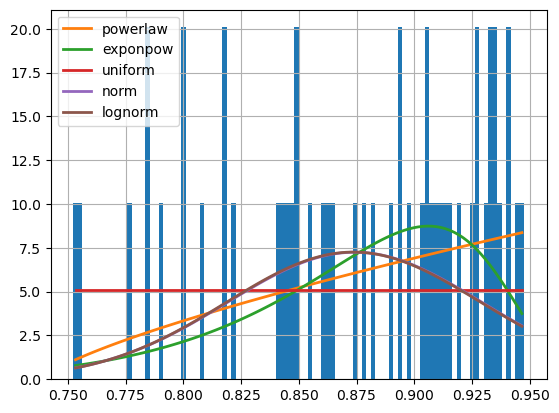

In [172]:
mostly_charged_distribution = determine_distribution(mostly_charged)
print(mostly_charged_distribution)

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 19.44it/s]


          sumsquare_error         aic         bic  kl_div  ks_statistic  \
uniform       4140.157562 -278.307320  170.325093     inf      0.117243   
powerlaw      4141.018600 -276.213710  173.858524     inf      0.118363   
norm          4257.544298 -241.793810  171.275689     inf      0.115885   
lognorm       4258.768004 -239.760766  174.811820     inf      0.117029   
gamma         4260.056613 -239.742558  174.822107     inf      0.120230   

          ks_pvalue  
uniform    0.694739  
powerlaw   0.683713  
norm       0.708051  
lognorm    0.696840  
gamma      0.665276  
{'uniform': {'loc': 0.5040736842105263, 'scale': 0.24376842105263152}}


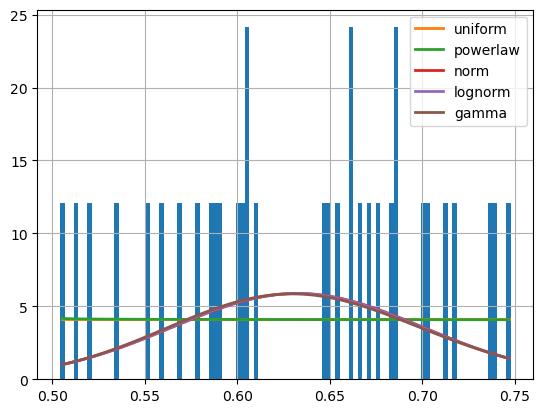

In [163]:
partially_charged_distribution = determine_distribution(partially_charged)
print(partially_charged_distribution)

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 19.72it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
cauchy      15883.561457 -206.901823  109.890947     inf      0.194479   
uniform     16459.849489 -318.319628  110.425537     inf      0.175502   
norm        16562.481746 -282.921121  110.518777     inf      0.186040   
gamma       16565.317021 -280.924661  113.229394     inf      0.187391   
lognorm     16571.159060 -280.906420  113.234683     inf      0.190115   

         ks_pvalue  
cauchy    0.557069  
uniform   0.681691  
norm      0.611959  
gamma     0.603084  
lognorm   0.585276  
{'cauchy': {'loc': 0.4046345646053891, 'scale': 0.025979654757393673}}


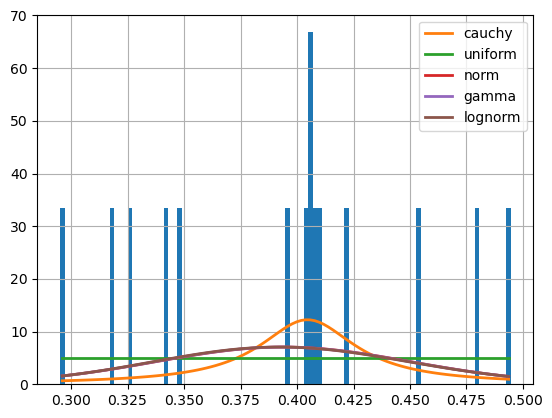

In [164]:
barely_charged_distribution = determine_distribution(barely_charged)
print(barely_charged_distribution)

#### Distributions
Mostly Charged was found to be described best by a Power Law Distribution

Partially Charged was found to be described best by a Uniform Distribution

Barely Charged was found to be described best by a Cauchy Distribution

In [173]:
# {'powerlaw': {'a': 1.7499123157860441, 'loc': 0.739214691236262, 'scale': 0.20836425616587315}}
def generate_random_variable_power_law(data):
    r = scipy.stats.powerlaw.rvs(a=data['a'], loc=data['loc'], scale=data['scale'], size=1)
    return r

# {'uniform': {'loc': 0.5040736842105263, 'scale': 0.24376842105263152}}
def generate_random_variable_uniform(data):
    r = scipy.stats.uniform.rvs(loc=data['loc'], scale=data['scale'], size=1)
    return r

# {'cauchy': {'loc': 0.4046345646053891, 'scale': 0.025979654757393673}}
def generate_random_variable_cauchy(data):
    r = scipy.stats.cauchy.rvs(loc=data['loc'], scale=data['scale'], size=1)
    r = np.clip(r, 0.1, 0.5)

    return r


In [174]:
print(generate_random_variable_power_law(mostly_charged_distribution['powerlaw']))
print(generate_random_variable_uniform(partially_charged_distribution['uniform']))
print(generate_random_variable_cauchy(barely_charged_distribution['cauchy']))

[0.84289626]
[0.68319356]
[0.41853882]


#### Going to graph my distribution after 1,000,000 pulls
This will take the likilihoods that it falls in the bin, then generate a number depending on the bin. Then, increment values binned every 5%.

In [194]:
draws = 1_000_000
values = np.zeros(20)
labels = [5 * i for i in range(20)]
for i in range(draws):
    random_number = np.random.uniform(0, 1)

    if random_number < likelihood_barely_charged:
        val = int(round(generate_random_variable_cauchy(barely_charged_distribution['cauchy'])[0], 2) * 100)
        index = val // 5
        values[index] += 1
    elif random_number < likelihood_barely_charged + likelihood_partially_charged:
        val = int(round(generate_random_variable_uniform(partially_charged_distribution['uniform'])[0], 2) * 100)
        index = val // 5
        values[index] += 1
    else:
        val = int(round(generate_random_variable_power_law(mostly_charged_distribution['powerlaw'])[0], 2) * 100)
        index = val // 5
        values[index] += 1

Text(0.5, 1.0, 'Combined Distribution for all 3 bins')

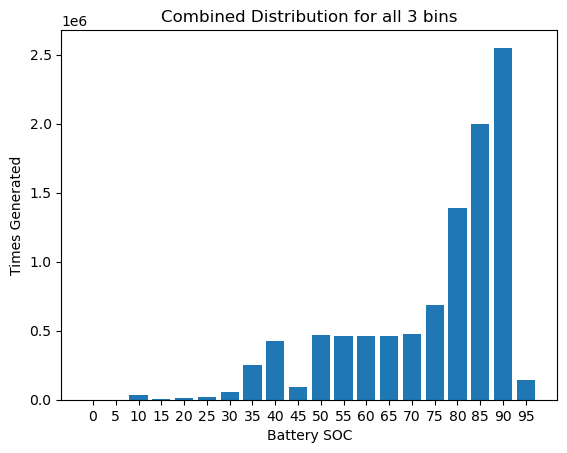

In [195]:
plt.bar(np.arange(values.size), values)
plt.xticks(ticks=np.arange(len(values)), labels=labels)
plt.xlabel("Battery SOC")
plt.ylabel("Times Generated")
plt.title("Combined Distribution for all 3 bins")

## Compute the Regularizing Constant

## Compute Posteriors and Graph Them